In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from coffea import util
from coffea.processor import accumulate
import os
import re
import pandas as pd
import hist
import matplotlib as mpl
import mplhep
import sys

sys.path.append("../../analysisTools/")
import plotTools as ptools

## Import coffea files -- signal and background

In [3]:
prefix = './coffea/skimmed/'
suffix = '_SR_v3_skimmed'

In [4]:
# Signal
f_sig = "signal"
sig_histo = util.load(f'{prefix}/{f_sig}{suffix}.coffea')[0]

In [5]:
# Background
bkg_files = {
    "QCD": "bkg_2018_QCD_TuneCP5_PSWeights", # No entry for QCD
    "Top": "bkg_2018_Top",
    "DY": "bkg_2018_DY",
    "Diboson": "bkg_2018_Diboson",
    "Triboson": "bkg_2018_Triboson",
    "W+jets": "bkg_2018_WJets",
    "Z+jets": "bkg_2018_ZJets",
}

bkg_histos = {}
histograms = []

for b in bkg_files.keys():
    bkg_histos[b] = util.load(f'{prefix}/{bkg_files[b]}{suffix}.coffea')[0]
    histograms = list(bkg_histos[b].keys())

## Signal

### Access the cutflow information

In [6]:
sig_samples = list(sig_histo['cutflow'].keys()) # names of signal sub-process, i.e. mass point, lifetime etc.

In [7]:
cuts = list(sig_histo['cutflow'][sig_samples[0]].keys())
print(cuts)

['all', 'hasVtx', 'cut5', 'cut6', 'cut7', 'cut8', 'cut9', 'cut10', 'cut11', 'cut12', 'cut13', 'cut14', 'cut15']


**Based on the signal file name, i.e. sig_2018_Mchi-55p0_dMchi-10p0_ctau-100, extract the mass point, lifetime, etc and make it into a pandas dataframe**: use `signalPoint` defined in `/python_analysis/analysisTools/plotTools.py`

In [8]:
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples}, orient='index')

**There are four cutflow-related variables in the coffea output.**

- `cutDesc`: cut names
- `cutflow`: efficiency = selected events / total events `cutflow[cutName] += np.sum(events.genWgt)/sum_wgt`
- `cutflow_cts`: reweighted by xsec `cutflow_counts[cutName] = xsec*lumi*cutflow[cutName]`
- `cutflow_nevts`: raw counts `cutflow_nevts[cutName] += len(events)` -- will not be used.
- `cutflow_vtx_matched`: (for signal MC only) fraction that the selected vertex (lowest chi2) passes the truth-matching (gen-matching)

**Access the cut names stored in cutDesc via getCut defined in `/python_analysis/analysisTools/plotTools.py`.** 
The function removes the redundant junk in `all` and `hasVtx` steps.

In [9]:
# cutflow
cutNames = {cname:ptools.getCut(sig_histo['cutDesc'][cname]) for cname in sig_histo['cutDesc'].keys()}
print(cutNames)

{'all': 'No cuts', 'hasVtx': 'Baseline Selection', 'cut5': 'No b-tagged jets', 'cut6': 'Leading jet |eta| < 2.4', 'cut7': 'Leading jet pT > 80 GeV', 'cut8': 'dPhi(MET,leading jet) > 1.5', 'cut9': 'dPhi(MET,all jets) > 0.75', 'cut10': 'OSSF', 'cut11': 'Vertex chi2/df < 3', 'cut12': 'dPhi(MET,vtx) < 1', 'cut13': 'm(ee) < 20', 'cut14': 'dR(ee) < 1.0', 'cut15': 'minDxy > 0.01'}


In [10]:
# signal efficiencies by delta/ctau
cf_s = sig_histo['cutflow']              # efficiency
ct_s = sig_histo['cutflow_cts']          # xsec-weighted event count
fr_s = sig_histo['cutflow_vtx_matched'] # fraction that selected vtx is truth-matched, for signal
desc = sig_histo['cutDesc']

In [11]:
# signal efficiencies by delta/ctau
raw_s = sig_histo['cutflow_nevts']

### Access the cutflow of the signal based on mass point, lifetime, etc

In [12]:
deltas = sorted(list(set(si.delta)))

print(f'deltas: {deltas}')

deltas: [0.1, 0.2]


In [13]:
delta = deltas[0]

m1s = sorted(list(set(si[si.delta==delta].m1)))
ctaus = sorted(list(set(si[si.delta==delta].ctau)))

print(f'For delta = {delta}: m1 = {m1s}, ctaus = {ctaus}')

For delta = 0.1: m1 = [5.0, 10.0, 20.0, 30.0, 40.0, 50.0], ctaus = [1.0, 10.0, 100.0]


In [14]:
delta = deltas[0]
m1 = m1s[0]
ct = ctaus[0]

pt = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
print(f'Signal sample with delta = {delta}, m1 = {m1}, ct = {ct}: {pt}\n')

effs = [cf_s[pt][cut] for cut in cuts]
print(f'Efficiency after each cut: {effs}')

Signal sample with delta = 0.1, m1 = 5.0, ct = 1.0: sig_2018_Mchi-5p25_dMchi-0p5_ctau-1

Efficiency after each cut: [0.01478160242543466, 0.0031361929210655046, 0.002708279622978362, 0.00256291784653054, 0.00256291784653054, 0.0013459248029797147, 0.0012712099695364075, 0.0008598302075909853, 0.00046530687175872285, 0.00044870387129589, 0.00044038487651958, 0.00038641551352642297, 0.00019115525424619447]


### Display the cutflow of efficiency and number of events as pandas dataframe

In [15]:
columns = list(cf_s.keys())

In [16]:
efficiency = {c: [ cf_s[samp][c] for samp in columns ] for c in cuts}

In [17]:
eff_df = pd.DataFrame.from_dict(efficiency).transpose()
eff_df.columns = columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

eff_df.index = cut

In [18]:
eff_df

,sig_2018_Mchi-5p5_dMchi-1p0_ctau-1,sig_2018_Mchi-5p5_dMchi-1p0_ctau-10,sig_2018_Mchi-5p5_dMchi-1p0_ctau-100,sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,sig_2018_Mchi-55p0_dMchi-10p0_ctau-100,sig_2018_Mchi-55p0_dMchi-10p0_ctau-10,sig_2018_Mchi-55p0_dMchi-10p0_ctau-1,sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,...,sig_2018_Mchi-22p0_dMchi-4p0_ctau-10,sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,sig_2018_Mchi-11p0_dMchi-2p0_ctau-100,sig_2018_Mchi-11p0_dMchi-2p0_ctau-10,sig_2018_Mchi-11p0_dMchi-2p0_ctau-1,sig_2018_Mchi-10p5_dMchi-1p0_ctau-10,sig_2018_Mchi-10p5_dMchi-1p0_ctau-100,sig_2018_Mchi-10p5_dMchi-1p0_ctau-1
Preselections,0.014484,0.010930,0.007414,0.007304,0.010659,0.014782,0.022439,0.031125,0.033826,0.032445,...,0.015844,0.018942,0.010649,0.016286,0.007997,0.012593,0.014729,0.012434,0.008054,0.015944
0 < n(jet) < 3 & n(good vertex) > 0,0.002886,0.001808,0.001127,0.001070,0.001788,0.003136,0.003937,0.007399,0.009426,0.006813,...,0.003001,0.004017,0.001609,0.003087,0.001084,0.002179,0.003148,0.002192,0.001168,0.003467
No b-tagged jets,0.002380,0.001501,0.000981,0.000907,0.001528,0.002708,0.003324,0.006364,0.007917,0.005813,...,0.002565,0.003370,0.001411,0.002710,0.000904,0.001784,0.002666,0.001895,0.000989,0.002960
Leading jet |eta| < 2.4,0.002244,0.001404,0.000933,0.000853,0.001447,0.002563,0.003218,0.006037,0.007607,0.005577,...,0.002421,0.003222,0.001343,0.002600,0.000852,0.001691,0.002542,0.001780,0.000924,0.002777
Leading jet pT > 80 GeV,0.002240,0.001401,0.000933,0.000853,0.001447,0.002563,0.003218,0.006037,0.007607,0.005575,...,0.002421,0.003220,0.001343,0.002597,0.000852,0.001691,0.002542,0.001780,0.000924,0.002777
"dPhi(MET,leading jet) > 1.5",0.001129,0.000673,0.000501,0.000433,0.000752,0.001346,0.001566,0.003053,0.003959,0.002790,...,0.001212,0.001627,0.000689,0.001320,0.000397,0.000817,0.001282,0.000923,0.000451,0.001380
"dPhi(MET,all jets) > 0.75",0.001074,0.000638,0.000463,0.000403,0.000691,0.001271,0.001463,0.002880,0.003736,0.002619,...,0.001128,0.001577,0.000631,0.001255,0.000352,0.000735,0.001206,0.000867,0.000422,0.001322
OSSF,0.000632,0.000393,0.000249,0.000211,0.000350,0.000860,0.000863,0.001983,0.002715,0.001736,...,0.000765,0.001086,0.000359,0.000775,0.000187,0.000447,0.000838,0.000524,0.000230,0.000886
Vertex chi2/df < 3,0.000309,0.000169,0.000065,0.000060,0.000138,0.000465,0.000353,0.001190,0.001781,0.000868,...,0.000403,0.000592,0.000125,0.000337,0.000061,0.000202,0.000444,0.000256,0.000081,0.000457
"dPhi(MET,vtx) < 1",0.000309,0.000169,0.000058,0.000050,0.000130,0.000449,0.000327,0.001155,0.001781,0.000830,...,0.000395,0.000577,0.000110,0.000322,0.000056,0.000198,0.000421,0.000241,0.000067,0.000444


In [19]:
purity = {c: [ fr_s[samp][c] for samp in columns ] for c in cuts}

In [20]:
purity_df = pd.DataFrame.from_dict(purity).transpose()
purity_df.columns = columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

purity_df.index = cut

In [21]:
purity_df

,sig_2018_Mchi-5p5_dMchi-1p0_ctau-1,sig_2018_Mchi-5p5_dMchi-1p0_ctau-10,sig_2018_Mchi-5p5_dMchi-1p0_ctau-100,sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,sig_2018_Mchi-55p0_dMchi-10p0_ctau-100,sig_2018_Mchi-55p0_dMchi-10p0_ctau-10,sig_2018_Mchi-55p0_dMchi-10p0_ctau-1,sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,...,sig_2018_Mchi-22p0_dMchi-4p0_ctau-10,sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,sig_2018_Mchi-11p0_dMchi-2p0_ctau-100,sig_2018_Mchi-11p0_dMchi-2p0_ctau-10,sig_2018_Mchi-11p0_dMchi-2p0_ctau-1,sig_2018_Mchi-10p5_dMchi-1p0_ctau-10,sig_2018_Mchi-10p5_dMchi-1p0_ctau-100,sig_2018_Mchi-10p5_dMchi-1p0_ctau-1
Preselections,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0 < n(jet) < 3 & n(good vertex) > 0,0.319274,0.196621,0.066503,0.048495,0.160302,0.300678,0.187506,0.383492,0.443749,0.303958,...,0.287077,0.336599,0.080807,0.230717,0.078478,0.237909,0.330039,0.226974,0.067855,0.303526
No b-tagged jets,0.330082,0.206964,0.069479,0.048947,0.167314,0.315971,0.196018,0.390265,0.460946,0.299585,...,0.302153,0.336555,0.080151,0.228706,0.078153,0.234474,0.341581,0.225613,0.067308,0.308153
Leading jet |eta| < 2.4,0.331896,0.204016,0.069378,0.049602,0.166651,0.320920,0.197482,0.391428,0.468083,0.301890,...,0.304250,0.340356,0.083292,0.225882,0.081233,0.235731,0.341388,0.231463,0.067020,0.309090
Leading jet pT > 80 GeV,0.332400,0.204515,0.069378,0.049602,0.166651,0.320920,0.197482,0.391428,0.468083,0.302020,...,0.304250,0.339904,0.083292,0.226100,0.081233,0.235731,0.341388,0.231463,0.067020,0.309090
"dPhi(MET,leading jet) > 1.5",0.307354,0.195013,0.068096,0.041023,0.150660,0.339532,0.198813,0.415348,0.483621,0.302540,...,0.327536,0.331503,0.094413,0.210153,0.072760,0.212264,0.355089,0.225550,0.063537,0.323570
"dPhi(MET,all jets) > 0.75",0.313439,0.200139,0.073600,0.044008,0.158179,0.339876,0.201799,0.422254,0.476615,0.304814,...,0.331652,0.332356,0.098857,0.209102,0.077912,0.228727,0.360826,0.234718,0.067849,0.331278
OSSF,0.516334,0.315999,0.123334,0.080932,0.288191,0.488009,0.323454,0.604501,0.656035,0.458414,...,0.486241,0.480712,0.166803,0.338682,0.146234,0.376000,0.516204,0.379773,0.124331,0.474618
Vertex chi2/df < 3,0.835342,0.653258,0.368736,0.250112,0.641831,0.812562,0.700081,0.898626,0.875018,0.814286,...,0.819211,0.821456,0.458507,0.703565,0.380935,0.760986,0.847772,0.702941,0.322467,0.797198
"dPhi(MET,vtx) < 1",0.835342,0.653258,0.412133,0.301437,0.682571,0.842629,0.725466,0.917961,0.875018,0.837566,...,0.835075,0.843391,0.517880,0.736371,0.410142,0.774692,0.893059,0.748315,0.390238,0.820414


In [22]:
eff_df * purity_df

,sig_2018_Mchi-5p5_dMchi-1p0_ctau-1,sig_2018_Mchi-5p5_dMchi-1p0_ctau-10,sig_2018_Mchi-5p5_dMchi-1p0_ctau-100,sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,sig_2018_Mchi-55p0_dMchi-10p0_ctau-100,sig_2018_Mchi-55p0_dMchi-10p0_ctau-10,sig_2018_Mchi-55p0_dMchi-10p0_ctau-1,sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,...,sig_2018_Mchi-22p0_dMchi-4p0_ctau-10,sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,sig_2018_Mchi-11p0_dMchi-2p0_ctau-100,sig_2018_Mchi-11p0_dMchi-2p0_ctau-10,sig_2018_Mchi-11p0_dMchi-2p0_ctau-1,sig_2018_Mchi-10p5_dMchi-1p0_ctau-10,sig_2018_Mchi-10p5_dMchi-1p0_ctau-100,sig_2018_Mchi-10p5_dMchi-1p0_ctau-1
Preselections,0.014484,0.010930,0.007414,0.007304,0.010659,0.014782,0.022439,0.031125,0.033826,0.032445,...,0.015844,0.018942,0.010649,0.016286,0.007997,0.012593,0.014729,0.012434,0.008054,0.015944
0 < n(jet) < 3 & n(good vertex) > 0,0.000921,0.000355,0.000075,0.000052,0.000287,0.000943,0.000738,0.002838,0.004183,0.002071,...,0.000861,0.001352,0.000130,0.000712,0.000085,0.000518,0.001039,0.000497,0.000079,0.001052
No b-tagged jets,0.000785,0.000311,0.000068,0.000044,0.000256,0.000856,0.000652,0.002484,0.003649,0.001741,...,0.000775,0.001134,0.000113,0.000620,0.000071,0.000418,0.000911,0.000427,0.000067,0.000912
Leading jet |eta| < 2.4,0.000745,0.000286,0.000065,0.000042,0.000241,0.000822,0.000636,0.002363,0.003561,0.001684,...,0.000737,0.001097,0.000112,0.000587,0.000069,0.000399,0.000868,0.000412,0.000062,0.000858
Leading jet pT > 80 GeV,0.000745,0.000286,0.000065,0.000042,0.000241,0.000822,0.000636,0.002363,0.003561,0.001684,...,0.000737,0.001094,0.000112,0.000587,0.000069,0.000399,0.000868,0.000412,0.000062,0.000858
"dPhi(MET,leading jet) > 1.5",0.000347,0.000131,0.000034,0.000018,0.000113,0.000457,0.000311,0.001268,0.001915,0.000844,...,0.000397,0.000539,0.000065,0.000277,0.000029,0.000173,0.000455,0.000208,0.000029,0.000446
"dPhi(MET,all jets) > 0.75",0.000337,0.000128,0.000034,0.000018,0.000109,0.000432,0.000295,0.001216,0.001781,0.000798,...,0.000374,0.000524,0.000062,0.000262,0.000027,0.000168,0.000435,0.000204,0.000029,0.000438
OSSF,0.000327,0.000124,0.000031,0.000017,0.000101,0.000420,0.000279,0.001199,0.001781,0.000796,...,0.000372,0.000522,0.000060,0.000262,0.000027,0.000168,0.000433,0.000199,0.000029,0.000421
Vertex chi2/df < 3,0.000259,0.000111,0.000024,0.000015,0.000089,0.000378,0.000247,0.001069,0.001558,0.000707,...,0.000330,0.000487,0.000057,0.000237,0.000023,0.000154,0.000376,0.000180,0.000026,0.000364
"dPhi(MET,vtx) < 1",0.000259,0.000111,0.000024,0.000015,0.000089,0.000378,0.000237,0.001061,0.001558,0.000695,...,0.000330,0.000487,0.000057,0.000237,0.000023,0.000154,0.000376,0.000180,0.000026,0.000364


In [23]:
delta = deltas[0]
m1 = m1s[0]
ct = ctaus[0]

pt = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]

eff_df[pt]

Preselections                          0.014782
0 < n(jet) < 3 & n(good vertex) > 0    0.003136
No b-tagged jets                       0.002708
Leading jet |eta| < 2.4                0.002563
Leading jet pT > 80 GeV                0.002563
dPhi(MET,leading jet) > 1.5            0.001346
dPhi(MET,all jets) > 0.75              0.001271
OSSF                                   0.000860
Vertex chi2/df < 3                     0.000465
dPhi(MET,vtx) < 1                      0.000449
m(ee) < 20                             0.000440
dR(ee) < 1.0                           0.000386
minDxy > 0.01                          0.000191
Name: sig_2018_Mchi-5p25_dMchi-0p5_ctau-1, dtype: float64

In [24]:
purity_df[pt]

Preselections                          1.000000
0 < n(jet) < 3 & n(good vertex) > 0    0.300678
No b-tagged jets                       0.315971
Leading jet |eta| < 2.4                0.320920
Leading jet pT > 80 GeV                0.320920
dPhi(MET,leading jet) > 1.5            0.339532
dPhi(MET,all jets) > 0.75              0.339876
OSSF                                   0.488009
Vertex chi2/df < 3                     0.812562
dPhi(MET,vtx) < 1                      0.842629
m(ee) < 20                             0.858546
dR(ee) < 1.0                           0.978456
minDxy > 0.01                          0.978229
Name: sig_2018_Mchi-5p25_dMchi-0p5_ctau-1, dtype: float64

In [25]:
(eff_df*purity_df)[pt]

Preselections                          0.014782
0 < n(jet) < 3 & n(good vertex) > 0    0.000943
No b-tagged jets                       0.000856
Leading jet |eta| < 2.4                0.000822
Leading jet pT > 80 GeV                0.000822
dPhi(MET,leading jet) > 1.5            0.000457
dPhi(MET,all jets) > 0.75              0.000432
OSSF                                   0.000420
Vertex chi2/df < 3                     0.000378
dPhi(MET,vtx) < 1                      0.000378
m(ee) < 20                             0.000378
dR(ee) < 1.0                           0.000378
minDxy > 0.01                          0.000187
Name: sig_2018_Mchi-5p25_dMchi-0p5_ctau-1, dtype: float64

#### Cutflow of number of events (xsec weighted counts)

In [26]:
columns_ctau = {'1': {'0p1': [], '0p2': []}, '10': {'0p1': [], '0p2': []}, '100': {'0p1': [], '0p2': []}}

for name in columns:
    mchi = int(name.split('-')[1].split('p')[0])
    dmchi = int(name.split('-')[2].split('p')[0])

    delta = round(dmchi / mchi, 1)

    if 'ctau-10' not in name:
        if delta == 0.1:
            columns_ctau['1']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['1']['0p2'].append(name)
    elif 'ctau-100' not in name:
        if delta == 0.1:
            columns_ctau['10']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['10']['0p2'].append(name)
    else:
        if delta == 0.1:
            columns_ctau['100']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['100']['0p2'].append(name)

ct = '10'
delta = '0p1'
print(columns_ctau[ct][delta])

['sig_2018_Mchi-52p5_dMchi-5p0_ctau-10', 'sig_2018_Mchi-42p0_dMchi-4p0_ctau-10', 'sig_2018_Mchi-31p5_dMchi-3p0_ctau-10', 'sig_2018_Mchi-21p0_dMchi-2p0_ctau-10', 'sig_2018_Mchi-10p5_dMchi-1p0_ctau-10']


In [27]:
counts = {}
purities = {}

for ct in columns_ctau.keys():
    counts[ct] = {}
    purities[ct] = {}
    for delta in ['0p1', '0p2']:
        counts[ct][delta] = {}
        purities[ct][delta] = {}
        for samp in columns_ctau[ct][delta]:
            counts[ct][delta][samp] = {}
            purities[ct][delta][samp] = {}
            for c in cuts:
                counts[ct][delta][samp][c] = ct_s[samp][c]
                purities[ct][delta][samp][c] = fr_s[samp][c]

In [28]:
#cts_df = {ct: pd.DataFrame.from_dict(counts[ct]).transpose() for ct in columns_ctau.keys()}

cts_df = {}
purities_df = {}

for ct in columns_ctau.keys():
    cts_df[ct] = {delta: pd.DataFrame.from_dict(counts[ct][delta]) for delta in ['0p1', '0p2']}
    purities_df[ct] = {delta: pd.DataFrame.from_dict(purities[ct][delta]) for delta in ['0p1', '0p2']}
    #cts_df[ct] = {delta: pd.DataFrame.from_dict(counts[ct]).transpose()}
    
    for delta in ['0p1', '0p2']:
        cts_df[ct][delta].columns = [ s.replace('sig_2018_', '') for s in columns_ctau[ct][delta] ]
        purities_df[ct][delta].columns = [ s.replace('sig_2018_', '') for s in columns_ctau[ct][delta] ]
    
        labels = [cutNames[c] for c in cuts]
        # Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
        cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
        cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))
        
        cts_df[ct][delta].index = cut
        purities_df[ct][delta].index = cut

In [29]:
pd.options.display.float_format = '{:,.2f}'.format

ct = '1'
delta = '0p1'
cts_df[ct][delta]

,Mchi-52p5_dMchi-5p0_ctau-1,Mchi-42p0_dMchi-4p0_ctau-1,Mchi-31p5_dMchi-3p0_ctau-1,Mchi-21p0_dMchi-2p0_ctau-1,Mchi-10p5_dMchi-1p0_ctau-1
Preselections,"6,585.30","16,108.59","33,794.91","30,374.51","39,435.84"
0 < n(jet) < 3 & n(good vertex) > 0,"1,608.58","3,781.03","7,356.16","6,441.61","8,575.27"
No b-tagged jets,"1,393.45","3,246.95","6,314.43","5,403.50","7,321.97"
Leading jet |eta| < 2.4,"1,337.61","3,103.23","6,072.37","5,166.74","6,868.71"
Leading jet pT > 80 GeV,"1,337.61","3,100.49","6,072.37","5,163.21","6,868.71"
"dPhi(MET,leading jet) > 1.5",654.38,"1,444.16","3,040.91","2,609.57","3,412.88"
"dPhi(MET,all jets) > 0.75",625.41,"1,382.53","2,926.77","2,528.26","3,268.96"
OSSF,419.01,930.71,"1,962.38","1,740.66","2,191.80"
Vertex chi2/df < 3,240.51,550.27,"1,028.11",949.77,"1,130.88"
"dPhi(MET,vtx) < 1",234.82,535.19,997.88,925.07,"1,098.88"


In [30]:
purities_df[ct][delta]

,Mchi-52p5_dMchi-5p0_ctau-1,Mchi-42p0_dMchi-4p0_ctau-1,Mchi-31p5_dMchi-3p0_ctau-1,Mchi-21p0_dMchi-2p0_ctau-1,Mchi-10p5_dMchi-1p0_ctau-1
Preselections,1.00,1.00,1.00,1.00,1.00
0 < n(jet) < 3 & n(good vertex) > 0,0.37,0.35,0.33,0.34,0.30
No b-tagged jets,0.38,0.36,0.33,0.34,0.31
Leading jet |eta| < 2.4,0.38,0.36,0.33,0.34,0.31
Leading jet pT > 80 GeV,0.38,0.35,0.33,0.34,0.31
"dPhi(MET,leading jet) > 1.5",0.37,0.37,0.33,0.33,0.32
"dPhi(MET,all jets) > 0.75",0.37,0.38,0.33,0.33,0.33
OSSF,0.56,0.56,0.49,0.48,0.47
Vertex chi2/df < 3,0.85,0.85,0.82,0.82,0.80
"dPhi(MET,vtx) < 1",0.86,0.87,0.85,0.84,0.82


In [31]:
cts_df[ct][delta] * purities_df[ct][delta]

,Mchi-52p5_dMchi-5p0_ctau-1,Mchi-42p0_dMchi-4p0_ctau-1,Mchi-31p5_dMchi-3p0_ctau-1,Mchi-21p0_dMchi-2p0_ctau-1,Mchi-10p5_dMchi-1p0_ctau-1
Preselections,"6,585.30","16,108.59","33,794.91","30,374.51","39,435.84"
0 < n(jet) < 3 & n(good vertex) > 0,594.82,"1,323.76","2,402.99","2,168.24","2,602.81"
No b-tagged jets,525.02,"1,153.91","2,053.37","1,818.58","2,256.29"
Leading jet |eta| < 2.4,507.45,"1,101.91","1,979.34","1,758.53","2,123.05"
Leading jet pT > 80 GeV,507.45,"1,100.55","1,979.34","1,755.00","2,123.05"
"dPhi(MET,leading jet) > 1.5",242.58,536.54,994.64,865.08,"1,104.30"
"dPhi(MET,all jets) > 0.75",232.75,524.21,961.02,840.28,"1,082.93"
OSSF,232.75,521.47,954.33,836.76,"1,040.27"
Vertex chi2/df < 3,203.79,465.38,843.32,780.20,901.53
"dPhi(MET,vtx) < 1",201.72,465.38,843.32,780.20,901.53


In [32]:
ct = '10'
delta = '0p1'
samp = 'Mchi-52p5_dMchi-5p0_ctau-10'

cts_df[ct][delta][samp]

Preselections                         625.95
0 < n(jet) < 3 & n(good vertex) > 0   131.44
No b-tagged jets                      112.14
Leading jet |eta| < 2.4               107.60
Leading jet pT > 80 GeV               107.55
dPhi(MET,leading jet) > 1.5            53.83
dPhi(MET,all jets) > 0.75              50.53
OSSF                                   33.50
Vertex chi2/df < 3                     16.75
dPhi(MET,vtx) < 1                      16.01
m(ee) < 20                             15.92
dR(ee) < 1.0                           12.81
minDxy > 0.01                          10.63
Name: Mchi-52p5_dMchi-5p0_ctau-10, dtype: float64

In [33]:
purities_df[ct][delta][samp]

Preselections                         1.00
0 < n(jet) < 3 & n(good vertex) > 0   0.30
No b-tagged jets                      0.30
Leading jet |eta| < 2.4               0.30
Leading jet pT > 80 GeV               0.30
dPhi(MET,leading jet) > 1.5           0.30
dPhi(MET,all jets) > 0.75             0.30
OSSF                                  0.46
Vertex chi2/df < 3                    0.81
dPhi(MET,vtx) < 1                     0.84
m(ee) < 20                            0.84
dR(ee) < 1.0                          0.94
minDxy > 0.01                         0.96
Name: Mchi-52p5_dMchi-5p0_ctau-10, dtype: float64

In [34]:
cts_df[ct][delta][samp] * purities_df[ct][delta][samp]

Preselections                         625.95
0 < n(jet) < 3 & n(good vertex) > 0    39.95
No b-tagged jets                       33.60
Leading jet |eta| < 2.4                32.48
Leading jet pT > 80 GeV                32.48
dPhi(MET,leading jet) > 1.5            16.29
dPhi(MET,all jets) > 0.75              15.40
OSSF                                   15.36
Vertex chi2/df < 3                     13.64
dPhi(MET,vtx) < 1                      13.41
m(ee) < 20                             13.41
dR(ee) < 1.0                           12.06
minDxy > 0.01                          10.21
Name: Mchi-52p5_dMchi-5p0_ctau-10, dtype: float64

### Plot the efficiency

In [35]:
def plot_efficiency_signal(df_sig, dict_eff, cuts, cutNames, m1, delta, ct, doLog=True, doSave=False, outDir = 'plots/cutflow/', outName='efficiency.png'):
    pt = df_sig[(df_sig.delta==delta) & (df_sig.m1==m1) & (df_sig.ctau==ct)].name[0]
    effs = [dict_eff[pt][cut] for cut in cuts]

    plt.plot( np.arange(len(cuts)), effs )

    if doLog:
        plt.yscale('log')

    plt.ylabel('Efficiency')
    
    labels = [cutNames[c] for c in cuts]
    # Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
    cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
    cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))
    
    plt.xticks(ticks = np.arange(len(cuts)), labels = cut, rotation = 45, ha = 'right')

    plt.grid()

    plt.title(r"$M_1 = {}$ GeV, $\Delta = {:.1f}$, $c\tau = {}$ mm".format(m1, delta, ct))
    
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}')
        print(f'Saved: {outDir}/{outName}')

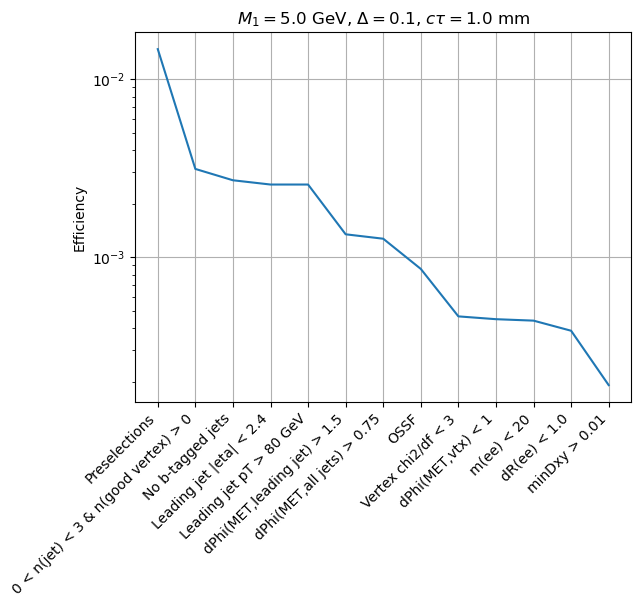

In [36]:
delta = deltas[0]
m1 = m1s[0]
ct = ctaus[0]

plot_efficiency_signal( df_sig = si, dict_eff = cf_s, cuts = cuts, cutNames = cutNames, 
                        m1 = m1, delta = delta, ct = ct, 
                        doSave = False, outDir = './plots/cutflow/', outName = f'efficiency_m1_{m1}_delta_{delta}_ct_{ct}.png')

Text(0.5, 1.0, 'Fraction that the selected vertex is truth-matched')

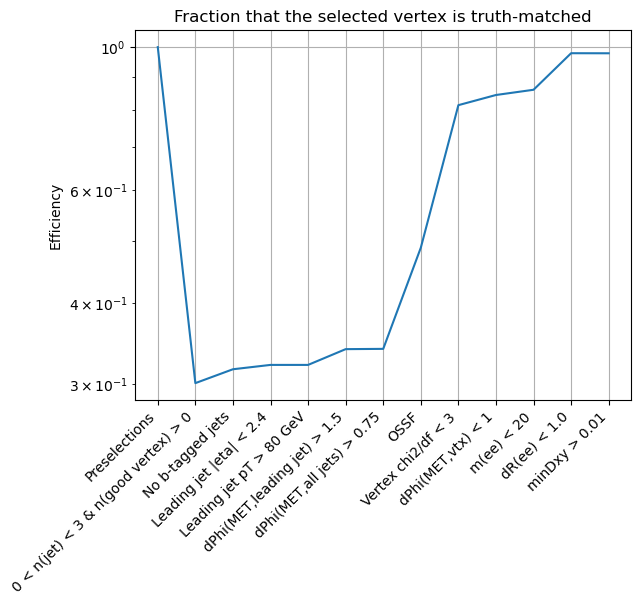

In [37]:
delta = deltas[0]
m1 = m1s[0]
ct = ctaus[0]

plot_efficiency_signal( df_sig = si, dict_eff = fr_s, cuts = cuts, cutNames = cutNames, 
                        m1 = m1, delta = delta, ct = ct, 
                        doSave = False, outDir = './plots/cutflow/', outName = f'purity_m1_{m1}_delta_{delta}_ct_{ct}.png')

plt.title('Fraction that the selected vertex is truth-matched')

#### Plot the efficiency and counts with varying m1's overlaid

In [38]:
def plot_efficiency_signal_varying_M1(df_sig, dict_eff, cuts, cutNames, delta, ct, ylim = [1e-5,5e-2], ylabel='Efficiency', doLegend=True, doLog=True, doSave=False, outDir = 'plots/cutflow/', outName='efficiency.png'):
    m1s = sorted(list(set(df_sig[(df_sig.delta==delta)&(df_sig.ctau==ct)].m1)))
        
    for m1 in m1s:
        pt = df_sig[(df_sig.delta==delta) & (df_sig.m1==m1) & (df_sig.ctau==ct)].name[0]
        effs = [dict_eff[pt][cut] for cut in cuts]
        plt.plot(np.arange(len(cuts)), effs, label=r"$M_1 = {0}$ GeV".format(m1), color=f"C{m1s.index(m1)}")

    if doLog:
        plt.yscale('log')

    plt.ylabel(ylabel)
    
    labels = [cutNames[c] for c in cuts]
    # Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
    cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
    cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))
    
    plt.xticks(ticks = np.arange(len(cuts)), labels = cut, rotation = 45, ha = 'right')

    plt.grid()

    plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))

    plt.ylim(ylim)
    
    if doLegend:
        plt.legend()
    
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}')
        print(f'Saved: {outDir}/{outName}')

In [39]:
def plot_counts_signal_varying_M1(df_sig, dict_eff, cuts, cutNames, delta, ct, ylabel='Events', doLegend=True, doLog=True, doSave=False, outDir = 'plots/cutflow/', outName='efficiency.png'):
    m1s = sorted(list(set(df_sig[(df_sig.delta==delta)&(df_sig.ctau==ct)].m1)))
        
    for m1 in m1s:
        pt = df_sig[(df_sig.delta==delta) & (df_sig.m1==m1) & (df_sig.ctau==ct)].name[0]
        effs = [dict_eff[pt][cut] for cut in cuts]
        plt.plot(np.arange(len(cuts)), effs, label=r"$M_1 = {0}$ GeV".format(m1), color=f"C{m1s.index(m1)}")

    if doLog:
        plt.yscale('log')

    plt.ylabel(ylabel)
    
    labels = [cutNames[c] for c in cuts]
    # Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
    cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
    cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))
    
    plt.xticks(ticks = np.arange(len(cuts)), labels = cut, rotation = 45, ha = 'right')

    plt.grid()

    plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))

    if doLegend:
        plt.legend()
    
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}')
        print(f'Saved: {outDir}/{outName}')

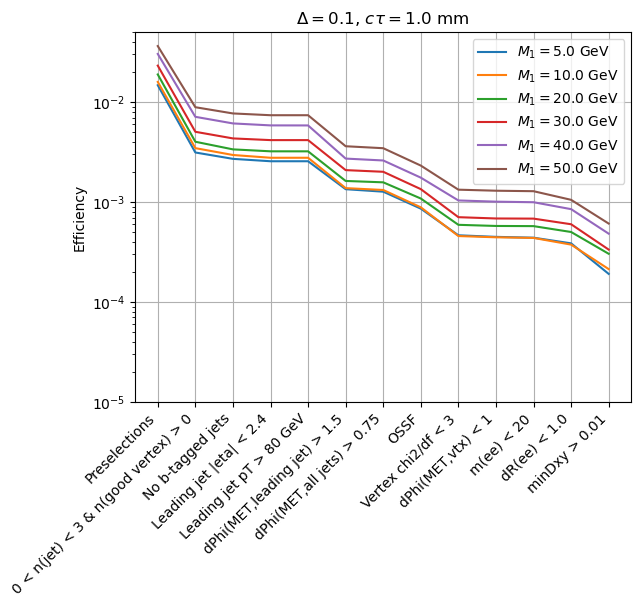

In [40]:
delta = deltas[0]
ct = ctaus[0]

plot_efficiency_signal_varying_M1( df_sig = si, dict_eff = cf_s, cuts = cuts, cutNames = cutNames, 
                                   delta = delta, ct = ct,
                                   doSave = False, outDir = 'plots/cutflow/', outName = f'efficiency_delta_{delta}_ct_{ct}.png')

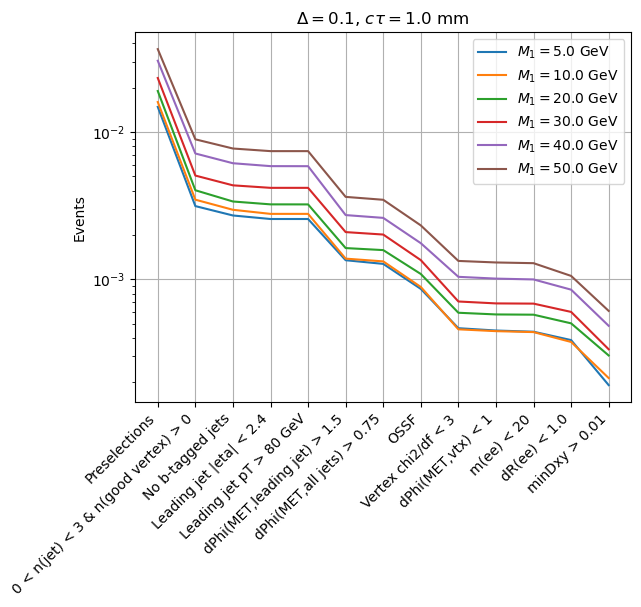

In [41]:
delta = deltas[0]
ct = ctaus[0]

plot_counts_signal_varying_M1( df_sig = si, dict_eff = cf_s, cuts = cuts, cutNames = cutNames, 
                                   delta = delta, ct = ct,
                                   doSave = False, outDir = 'plots/cutflow/', outName = f'counts_delta_{delta}_ct_{ct}.png')

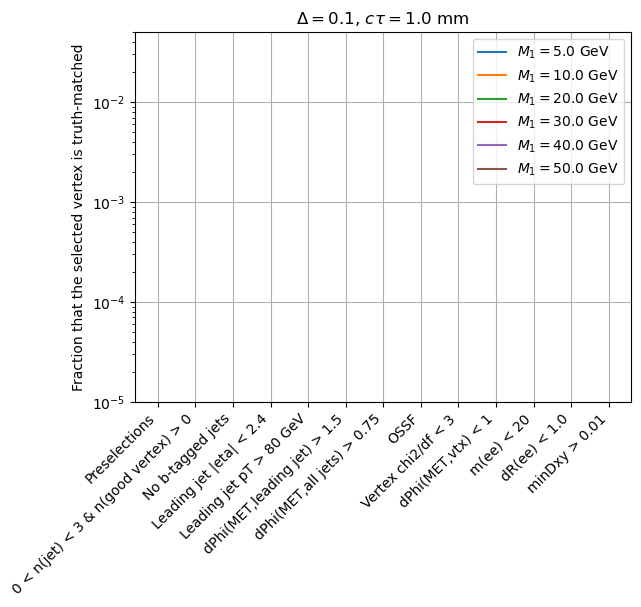

In [42]:
delta = deltas[0]
ct = ctaus[0]

plot_efficiency_signal_varying_M1( df_sig = si, dict_eff = fr_s, cuts = cuts, cutNames = cutNames, 
                                   delta = delta, ct = ct, ylabel='Fraction that the selected vertex is truth-matched',
                                   doSave = False, outDir = 'plots/cutflow/', outName = f'purity_delta_{delta}_ct_{ct}.png')

#### Plot with various ctaus on one axis

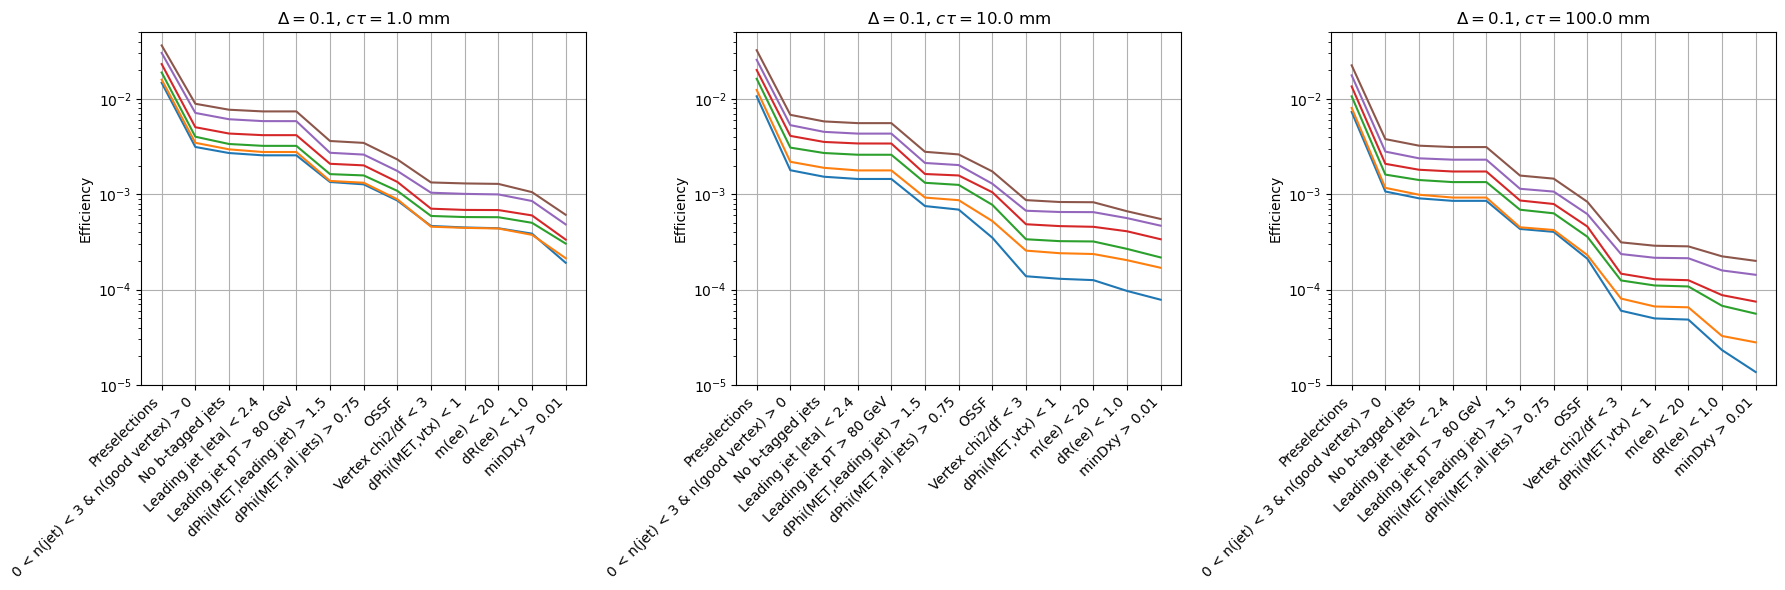

In [43]:
delta = deltas[0]
ctaus = sorted(list(set(si[si.delta==delta].ctau)))

fig,axes = plt.subplots(1,len(ctaus),figsize=(6*len(ctaus),6))

for i, ct in enumerate(ctaus):
    plt.sca(axes[i])
    plot_efficiency_signal_varying_M1( df_sig = si, dict_eff = cf_s, cuts = cuts, cutNames = cutNames, 
                                       delta = delta, ct = ct, doLegend=False )
plt.tight_layout()
plt.show()

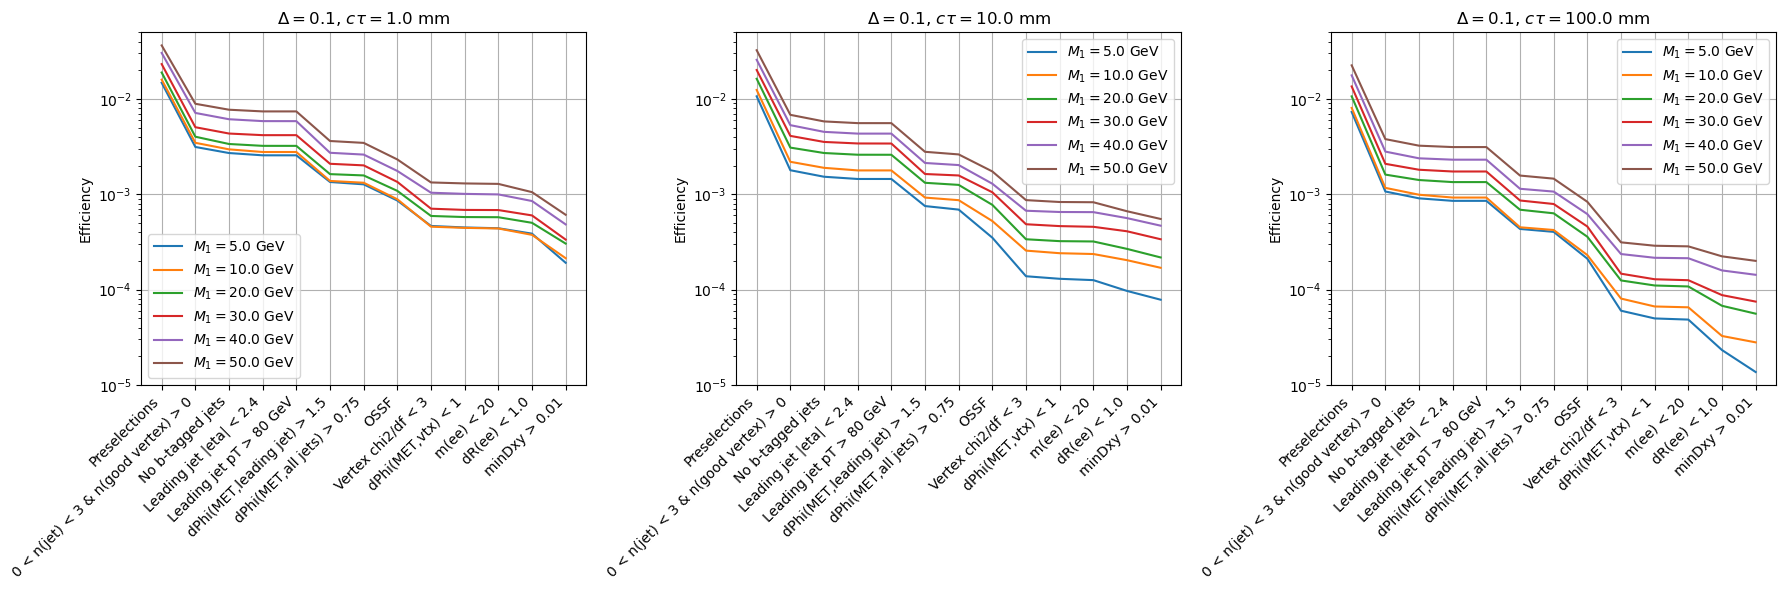

In [44]:
delta = deltas[0]
ctaus = sorted(list(set(si[si.delta==delta].ctau)))

fig,axes = plt.subplots(1,len(ctaus),figsize=(6*len(ctaus),6))

for i, ct in enumerate(ctaus):
    plt.sca(axes[i])
    plot_efficiency_signal_varying_M1( df_sig = si, dict_eff = cf_s, cuts = cuts, cutNames = cutNames, 
                                       delta = delta, ct = ct)
plt.tight_layout()
plt.show()

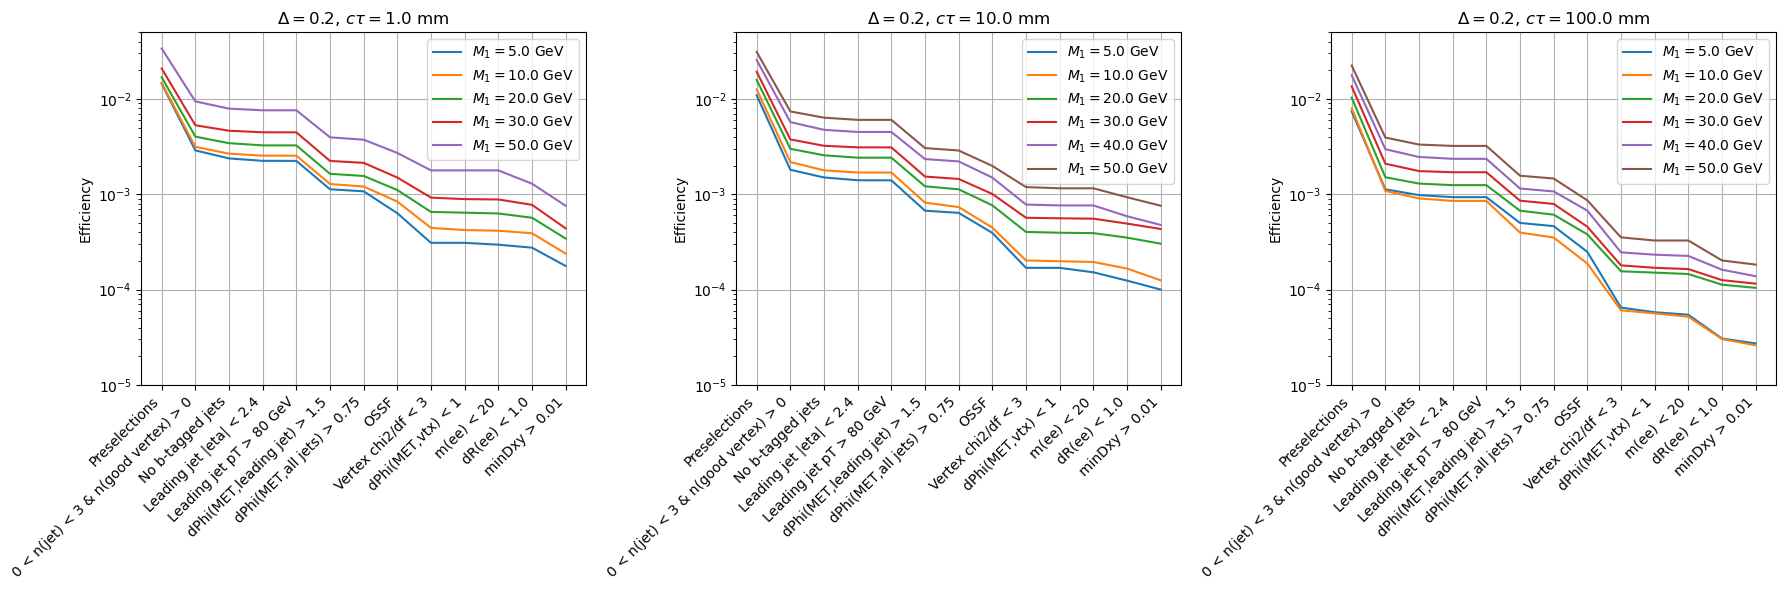

In [45]:
delta = deltas[1]
ctaus = sorted(list(set(si[si.delta==delta].ctau)))

fig,axes = plt.subplots(1,len(ctaus),figsize=(6*len(ctaus),6))

for i, ct in enumerate(ctaus):
    plt.sca(axes[i])
    plot_efficiency_signal_varying_M1( df_sig = si, dict_eff = cf_s, cuts = cuts, cutNames = cutNames, 
                                       delta = delta, ct = ct)
plt.tight_layout()
plt.show()

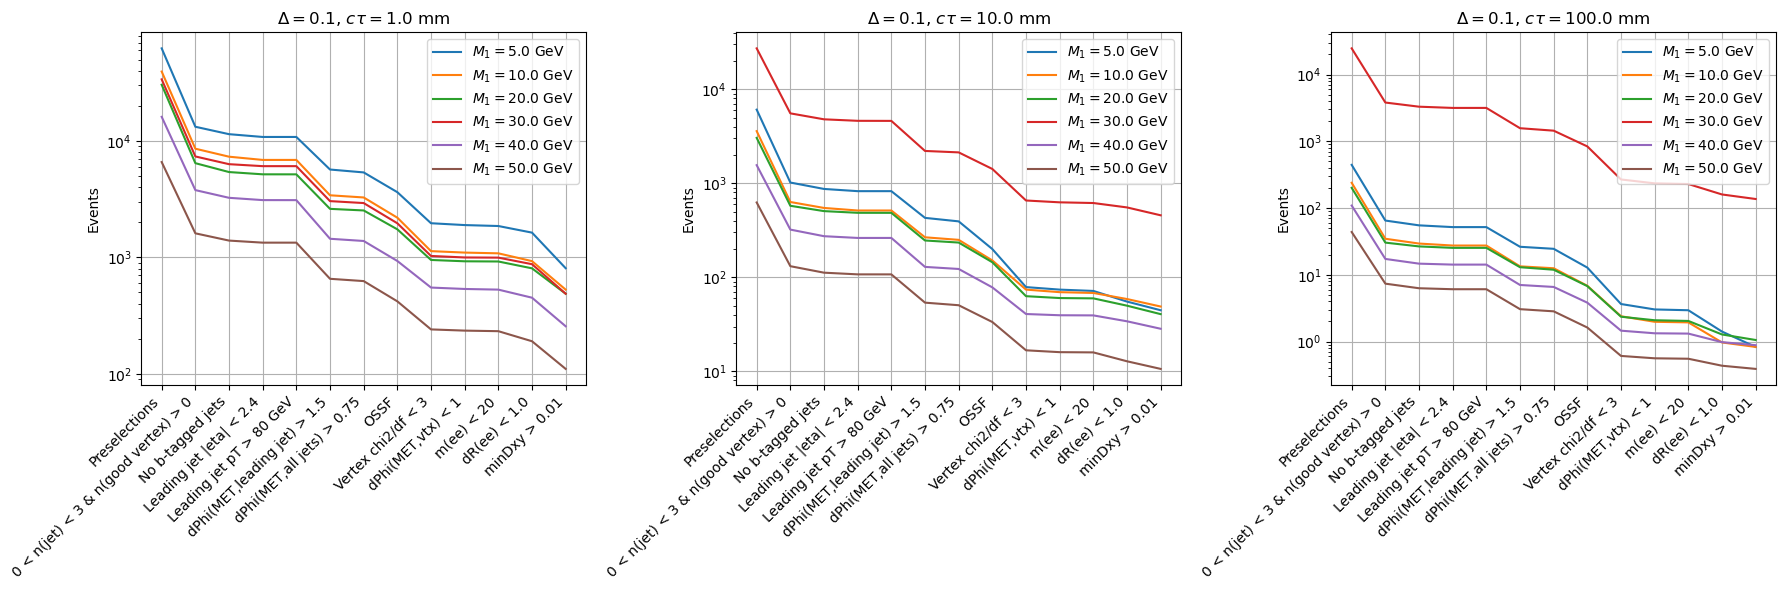

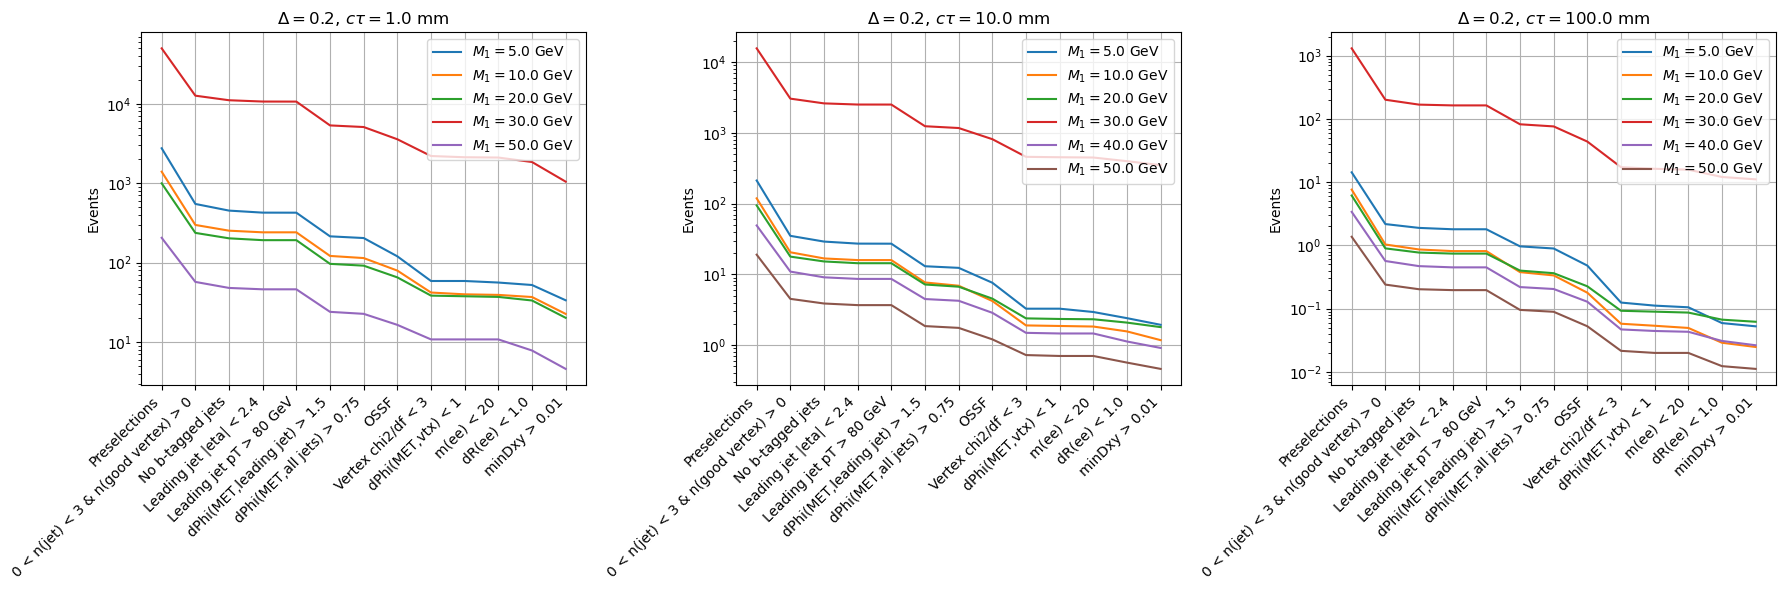

In [46]:
for delta in deltas:
    ctaus = sorted(list(set(si[si.delta==delta].ctau)))
    
    fig,axes = plt.subplots(1,len(ctaus),figsize=(6*len(ctaus),6))
    
    for i, ct in enumerate(ctaus):
        plt.sca(axes[i])
        plot_counts_signal_varying_M1( df_sig = si, dict_eff = ct_s, cuts = cuts, cutNames = cutNames, 
                                       delta = delta, ct = ct )
    plt.tight_layout()
    plt.show()

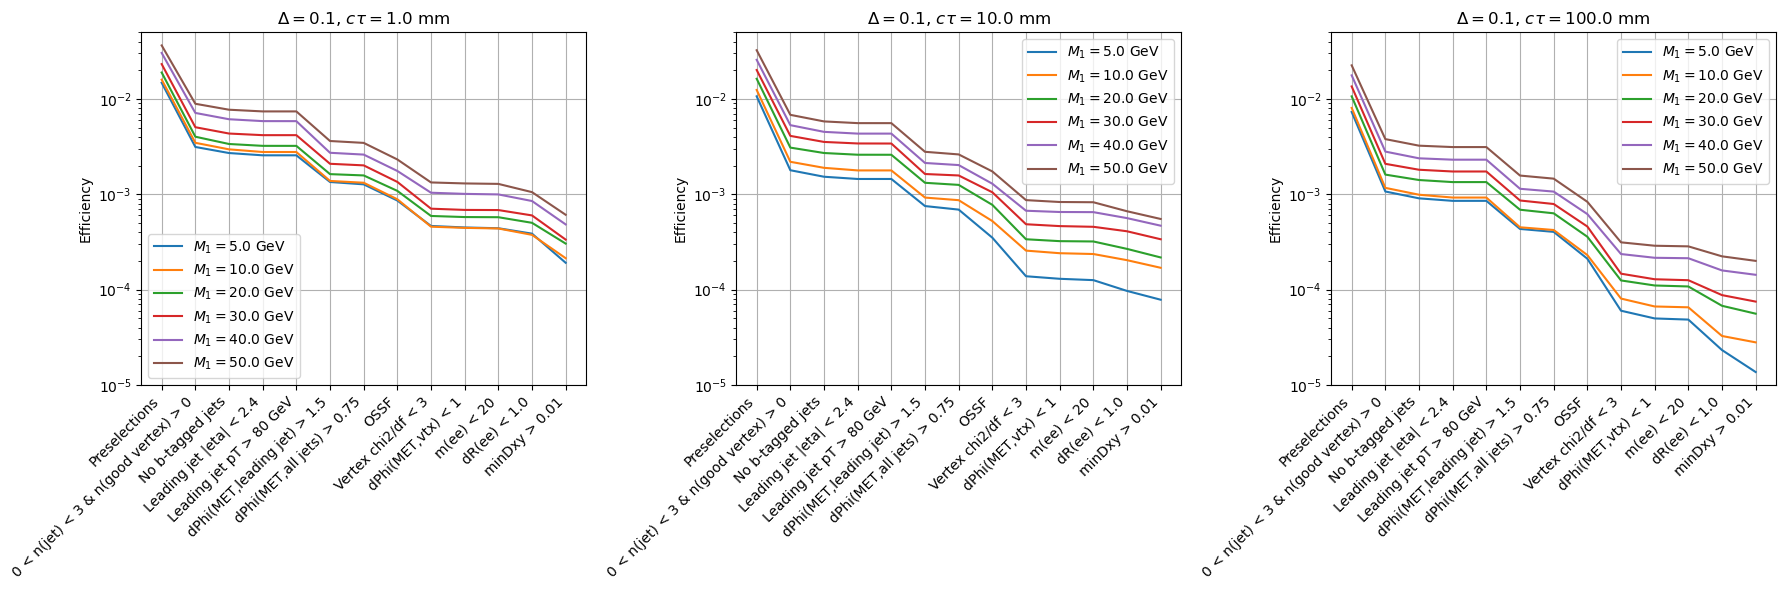

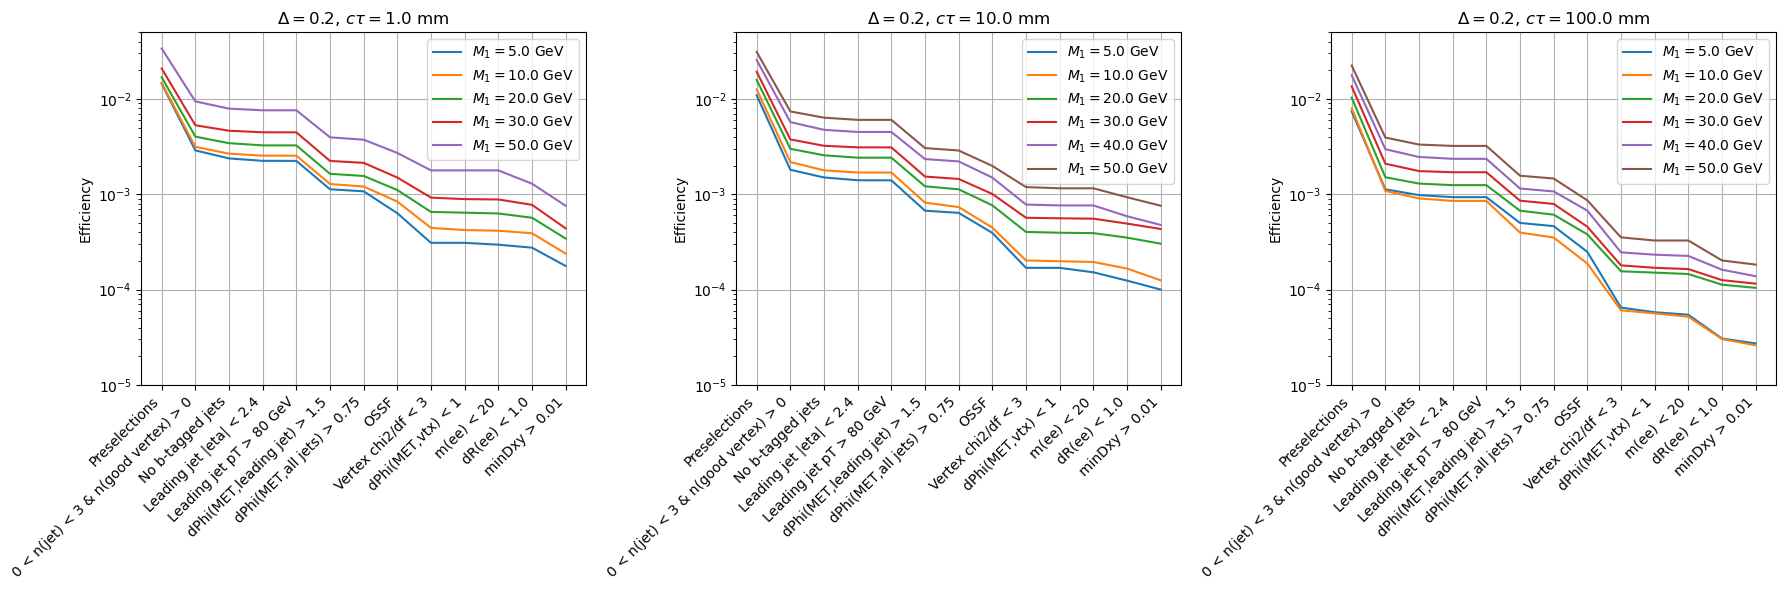

In [47]:
for delta in deltas:
    ctaus = sorted(list(set(si[si.delta==delta].ctau)))
    
    fig,axes = plt.subplots(1,len(ctaus),figsize=(6*len(ctaus),6))
    
    for i, ct in enumerate(ctaus):
        plt.sca(axes[i])
        plot_efficiency_signal_varying_M1( df_sig = si, dict_eff = cf_s, cuts = cuts, cutNames = cutNames, 
                                           delta = delta, ct = ct )
    plt.tight_layout()
    plt.show()

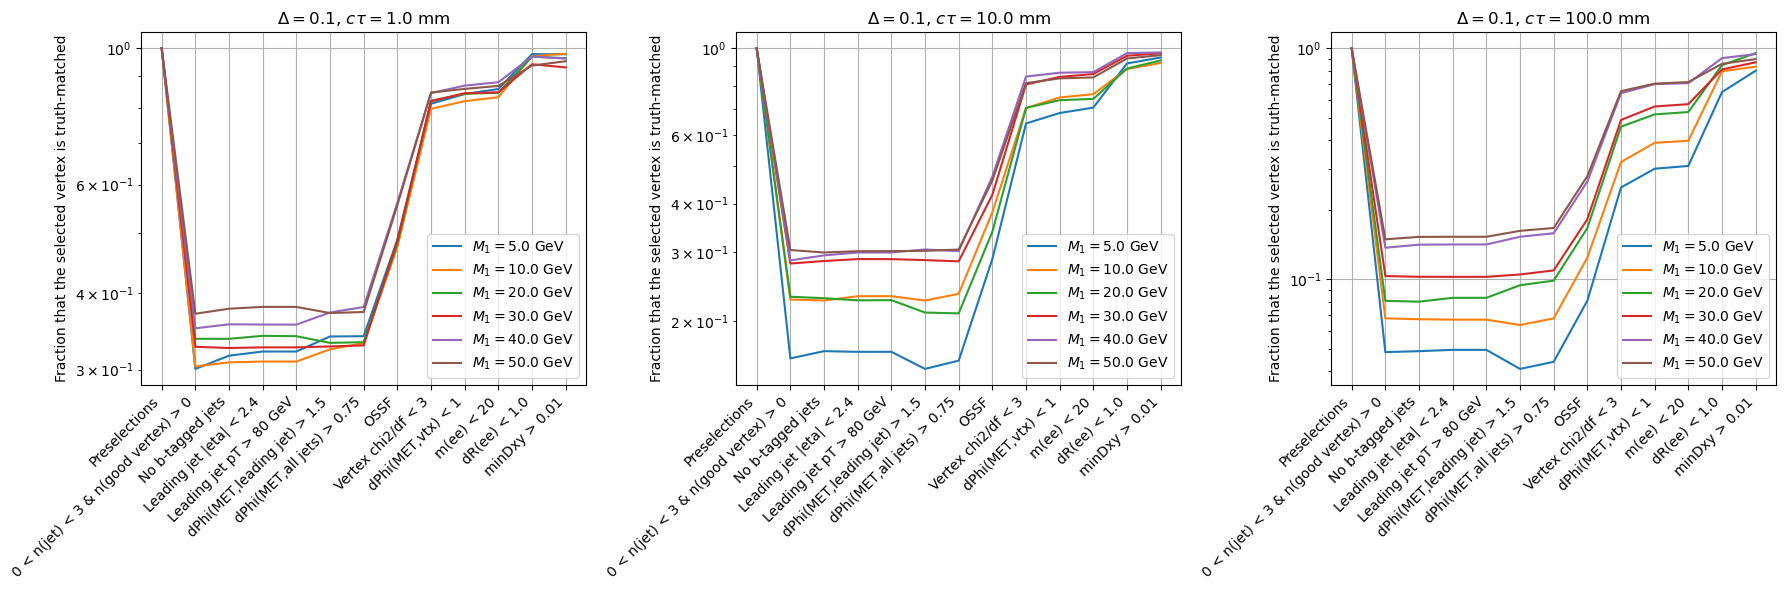

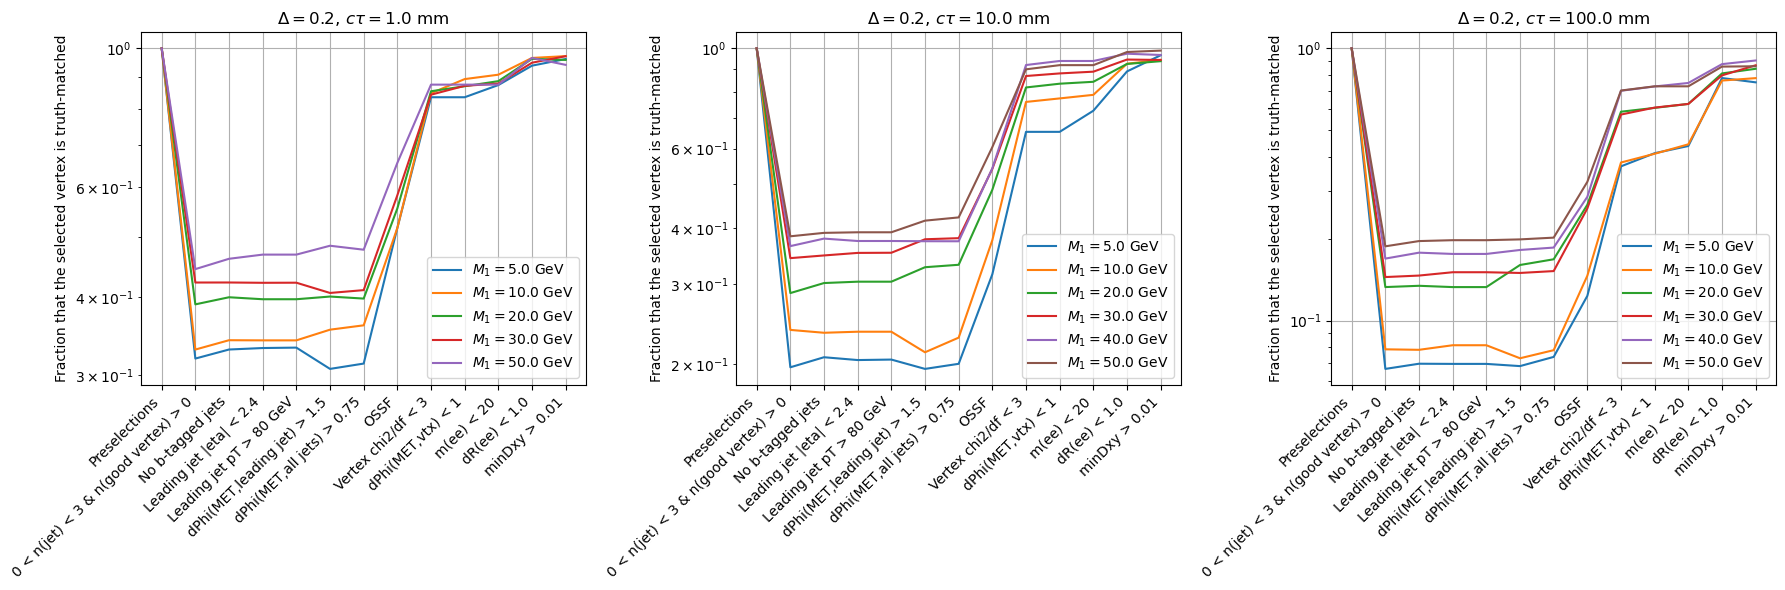

In [48]:
for delta in deltas:
    ctaus = sorted(list(set(si[si.delta==delta].ctau)))
    
    fig,axes = plt.subplots(1,len(ctaus),figsize=(6*len(ctaus),6))
    
    for i, ct in enumerate(ctaus):
        plt.sca(axes[i])
        plot_counts_signal_varying_M1( df_sig = si, dict_eff = fr_s, cuts = cuts, cutNames = cutNames, 
                                       delta = delta, ct = ct, ylabel='Fraction that the selected vertex is truth-matched')
    plt.tight_layout()
    plt.show()

## Background

For background processes, each process (i.e. Top) will have several sub-processes. In the coffea output file, we have efficiencies stored for each sub-processes. In order to get the efficiency of the process, not each sub-process, we have to do some math. In other words, we can't just add up efficiencies.

### Get cutflow information

In [49]:
cuts = list(bkg_histos['W+jets']['cutflow']['bkg_2018_WJetsLNu_HT2500toInf'])
print(cuts)

['all', 'hasVtx', 'cut5', 'cut6', 'cut7', 'cut8', 'cut9', 'cut10', 'cut11', 'cut12', 'cut13', 'cut14', 'cut15']


In [50]:
tot_bkg_cts = {} 
tot_bkg_effs = {} 
total_bkg_counts = {} 

In [51]:
for b in bkg_histos.keys():
    #print('\n')
    #print(b)
    
    total_bkg_counts[b] = 0
    for k in bkg_histos[b]['cutflow'].keys():
        #print(bkg_histos[b]['cutflow_cts'][k]['all']) # xsec * lumi * (np.sum(events.genWgt)/sum_wgt)
        #print(bkg_histos[b]['cutflow'][k]['all'])     # (np.sum(events.genWgt)/sum_wgt)

        #print(f"{k}: xsec * lumi = {bkg_histos[b]['cutflow_cts'][k]['all'] / bkg_histos[b]['cutflow'][k]['all']}")
        
        total_bkg_counts[b] += bkg_histos[b]['cutflow_cts'][k]['all'] / bkg_histos[b]['cutflow'][k]['all']

    print(f'\nxsec * lumi = {total_bkg_counts[b]} for all the sub-processes for {b}')


xsec * lumi = 21550273000.8 for all the sub-processes for QCD

xsec * lumi = 43775157.97 for all the sub-processes for Top

xsec * lumi = 1287302280.0 for all the sub-processes for DY

xsec * lumi = 6942074.9 for all the sub-processes for Diboson

xsec * lumi = 27423.080499999996 for all the sub-processes for Triboson

xsec * lumi = 98361983.44179998 for all the sub-processes for W+jets

xsec * lumi = 21401490.688470002 for all the sub-processes for Z+jets


In [52]:
for b in bkg_histos.keys():
    cfd = bkg_histos[b]['cutflow_cts']
    effd = bkg_histos[b]['cutflow']

    cts_dict = {k:0 for k in cuts}
    
    for k in cfd.keys():
        for c in cuts:
            #print(f'{k} at {c}: xsec * lumi * (np.sum(events.genWgt)/sum_wgt) = {cfd[k][c]}')
            
            cts_dict[c] += cfd[k][c]

    c = 'all'
    print(f'\n{b}:  xsec * lumi * eff at {cutNames[c]} = {cts_dict[c]}')
    
    tot_bkg_cts[b] = cts_dict # subprocess summed
    tot_bkg_effs[b] = {c:cts_dict[c]/total_bkg_counts[b] for c in cuts}

    #print(tot_bkg_cts[b][c])
    #print(total_bkg_counts[b]) # subprocess summed from previous cell


QCD:  xsec * lumi * eff at No cuts = 38039.826987393106

Top:  xsec * lumi * eff at No cuts = 5667.491119528111

DY:  xsec * lumi * eff at No cuts = 14495.724273410278

Diboson:  xsec * lumi * eff at No cuts = 4424.202427727811

Triboson:  xsec * lumi * eff at No cuts = 52.9969216443768

W+jets:  xsec * lumi * eff at No cuts = 227212.60103568572

Z+jets:  xsec * lumi * eff at No cuts = 142220.15349869026


In [53]:
bkg_summed_cts = {c:sum([tot_bkg_cts[b][c] for b in tot_bkg_cts.keys()]) for c in cuts}

c = 'cut12'
print(f'Total backgrounds (xsec * lumi * eff) at cut {cutNames[c]}: {bkg_summed_cts[c]}')

Total backgrounds (xsec * lumi * eff) at cut dPhi(MET,vtx) < 1: 1064.917650865737


In [54]:
bkg_summed_eff = {c: bkg_summed_cts[c] / sum(total_bkg_counts.values()) for c in cuts}

print(bkg_summed_eff)

{'all': 1.878092097231049e-05, 'hasVtx': 2.3803651294383054e-06, 'cut5': 1.90624245974092e-06, 'cut6': 1.8166633461303788e-06, 'cut7': 1.8135666037132028e-06, 'cut8': 8.793299302239876e-07, 'cut9': 4.942504113746767e-07, 'cut10': 2.6164458037513464e-07, 'cut11': 5.975883814792801e-08, 'cut12': 4.628450061868803e-08, 'cut13': 4.154592820562025e-08, 'cut14': 1.5904681909144662e-08, 'cut15': 3.454417205086605e-09}


### Display the efficiency and event count table in Pandas Dataframe

In [55]:
columns = list(bkg_histos.keys())
columns.append('total')

In [56]:
tot_bkg_effs['total'] = bkg_summed_eff

In [57]:
tot_bkg_cts['total'] = bkg_summed_cts

In [58]:
efficiency = {c: [ tot_bkg_effs[samp][c] for samp in columns ] for c in cuts}

In [59]:
eff_df = pd.DataFrame.from_dict(efficiency).transpose()
eff_df.columns = columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

eff_df.index = cut

In [60]:
pd.options.display.float_format = '{:.9f}'.format
eff_df

,QCD,Top,DY,Diboson,Triboson,W+jets,Z+jets,total
Preselections,0.000001765,0.000129468,0.000011261,0.000637303,0.001932566,0.002309964,0.006645339,0.000018781
0 < n(jet) < 3 & n(good vertex) > 0,0.000000137,0.000022551,0.000002143,0.000083145,0.000267797,0.000321131,0.000743060,0.000002380
No b-tagged jets,0.000000091,0.000014268,0.000001956,0.000061512,0.000179347,0.000257209,0.000608118,0.000001906
Leading jet |eta| < 2.4,0.000000090,0.000012667,0.000001956,0.000057643,0.000166498,0.000244045,0.000578392,0.000001817
Leading jet pT > 80 GeV,0.000000090,0.000012631,0.000001956,0.000057053,0.000165886,0.000243597,0.000577388,0.000001814
"dPhi(MET,leading jet) > 1.5",0.000000050,0.000006551,0.000000410,0.000028343,0.000081602,0.000121121,0.000290553,0.000000879
"dPhi(MET,all jets) > 0.75",0.000000014,0.000003253,0.000000373,0.000012256,0.000025458,0.000066457,0.000178249,0.000000494
OSSF,0.000000014,0.000001772,0.000000298,0.000006020,0.000018233,0.000033350,0.000089904,0.000000262
Vertex chi2/df < 3,0.000000000,0.000000480,0.000000111,0.000001490,0.000002270,0.000007849,0.000019998,0.000000060
"dPhi(MET,vtx) < 1",0.000000000,0.000000437,0.000000111,0.000001031,0.000001657,0.000006128,0.000013659,0.000000046


In [61]:
counts = {c: [ tot_bkg_cts[samp][c] for samp in columns ] for c in cuts}

counts['all']

[38039.826987393106,
 5667.491119528111,
 14495.724273410278,
 4424.202427727811,
 52.9969216443768,
 227212.60103568572,
 142220.15349869026,
 432112.9962640797]

In [62]:
cts_df = pd.DataFrame.from_dict(counts).transpose()
cts_df.columns = columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

cts_df.index = cut

In [63]:
pd.options.display.float_format = '{:,.2f}'.format
cts_df

,QCD,Top,DY,Diboson,Triboson,W+jets,Z+jets,total
Preselections,"38,039.83","5,667.49","14,495.72","4,424.20",53.00,"227,212.60","142,220.15","432,113.00"
0 < n(jet) < 3 & n(good vertex) > 0,"2,948.06",987.17,"2,758.17",577.20,7.34,"31,587.11","15,902.59","54,767.64"
No b-tagged jets,"1,970.00",624.57,"2,518.29",427.02,4.92,"25,299.55","13,014.63","43,858.99"
Leading jet |eta| < 2.4,"1,937.15",554.51,"2,518.29",400.16,4.57,"24,004.79","12,378.46","41,797.94"
Leading jet pT > 80 GeV,"1,937.15",552.94,"2,518.29",396.07,4.55,"23,960.73","12,356.96","41,726.69"
"dPhi(MET,leading jet) > 1.5","1,086.02",286.76,527.93,196.76,2.24,"11,913.73","6,218.26","20,231.70"
"dPhi(MET,all jets) > 0.75",312.20,142.38,479.75,85.08,0.70,"6,536.86","3,814.79","11,371.75"
OSSF,312.20,77.59,383.38,41.79,0.50,"3,280.39","1,924.08","6,019.94"
Vertex chi2/df < 3,0.00,20.99,143.51,10.34,0.06,772.05,427.98,"1,374.94"
"dPhi(MET,vtx) < 1",0.00,19.12,143.51,7.16,0.05,602.77,292.32,"1,064.92"


### Plot the efficiency

In [ ]:
# bkg efficiencies summed over sub-samples

plt.figure(figsize=(8,6))
plt.title("Background Efficiencies")

for b in bkg_histos.keys():
    cfbs = tot_bkg_effs[b]
    effs = [cfbs[c] for c in cuts]
    plt.plot(np.arange(len(effs)),effs,label=b)
    #plt.ylim([1e-12,1])

plt.yscale('log')
plt.ylabel("Efficiency")
plt.legend(loc='upper right',ncol=2)
plt.grid()

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))
    
plt.xticks(ticks = np.arange(len(cuts)), labels = cut, rotation = 45, ha = 'right')

plt.ylim([1e-8, 5e-2])
plt.show()

#os.makedirs("plots/cutflows/")
#plt.savefig(f"plots/cutflows/bkg_combined_efficiencies.png")

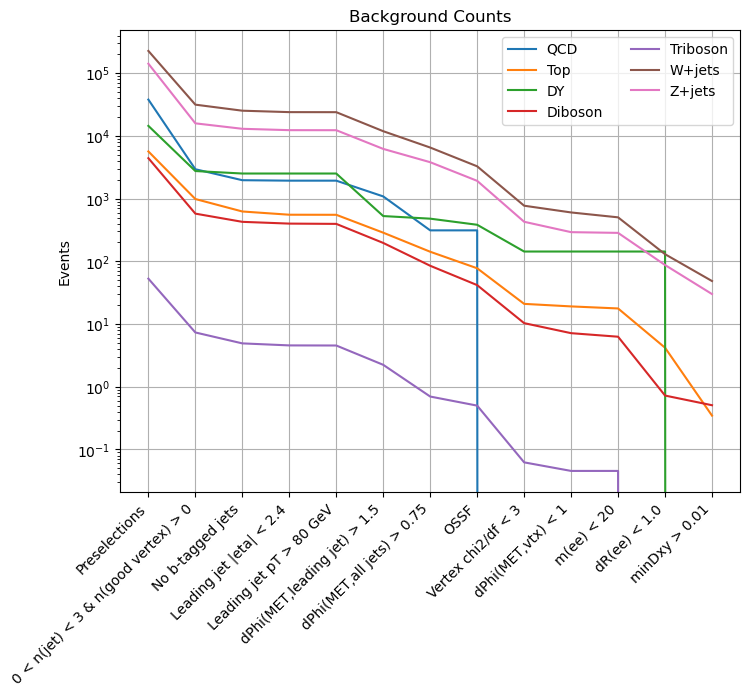

In [65]:
# bkg counts
plt.figure(figsize=(8,6))
plt.title("Background Counts")

for b in bkg_histos.keys():
    cf = tot_bkg_cts[b]
    effs = [cf[c] for c in cuts]
    plt.plot(np.arange(len(effs)), effs, label=b)
    
plt.yscale('log')
plt.ylabel('Events')
plt.legend(loc='upper right',ncol=2)
plt.grid()

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))
    
plt.xticks(ticks = np.arange(len(cuts)), labels = cut, rotation = 45, ha = 'right')

plt.show()

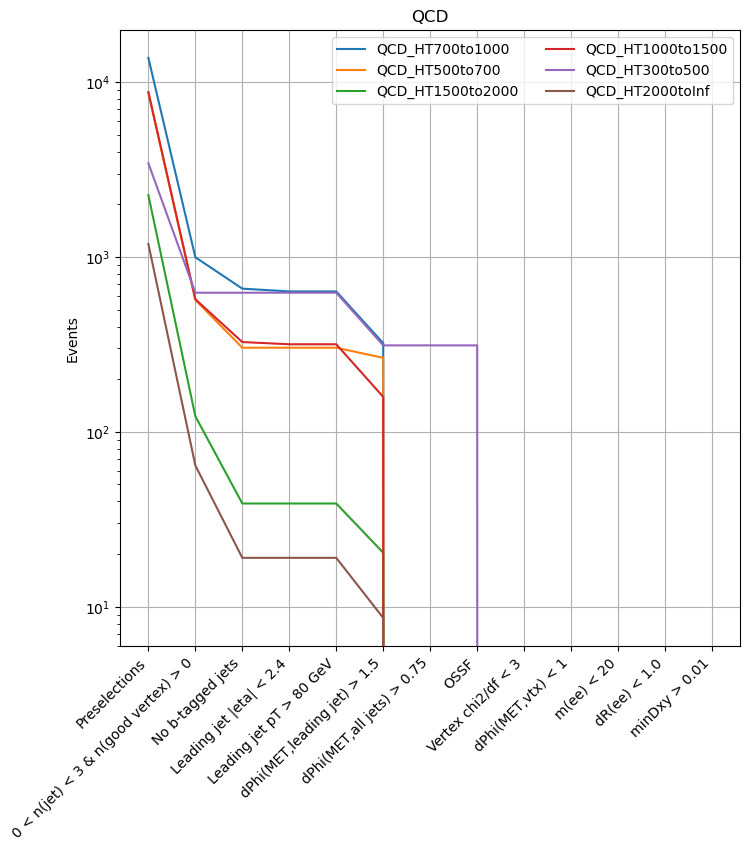

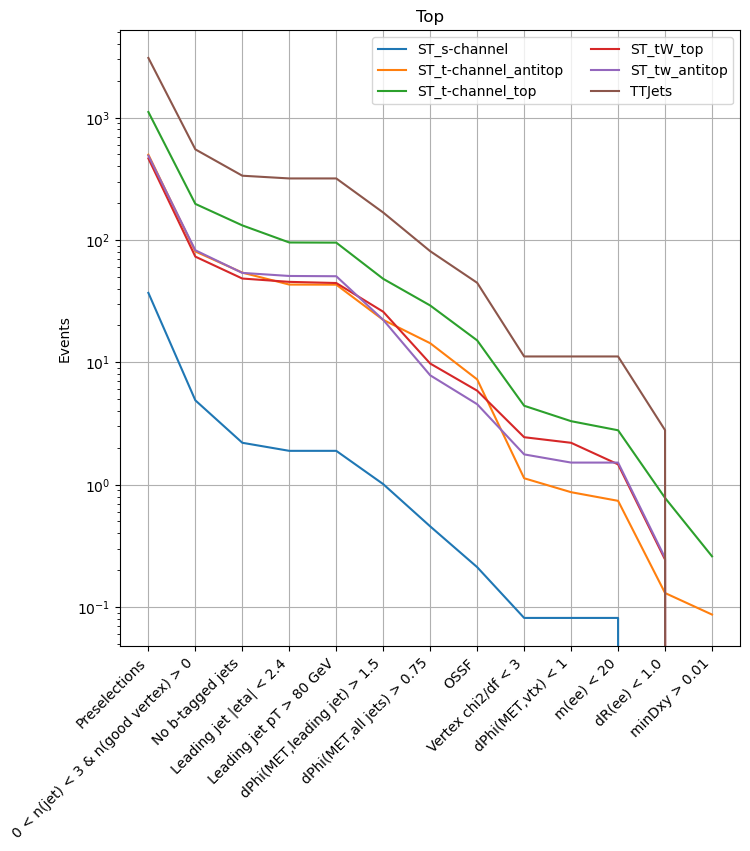

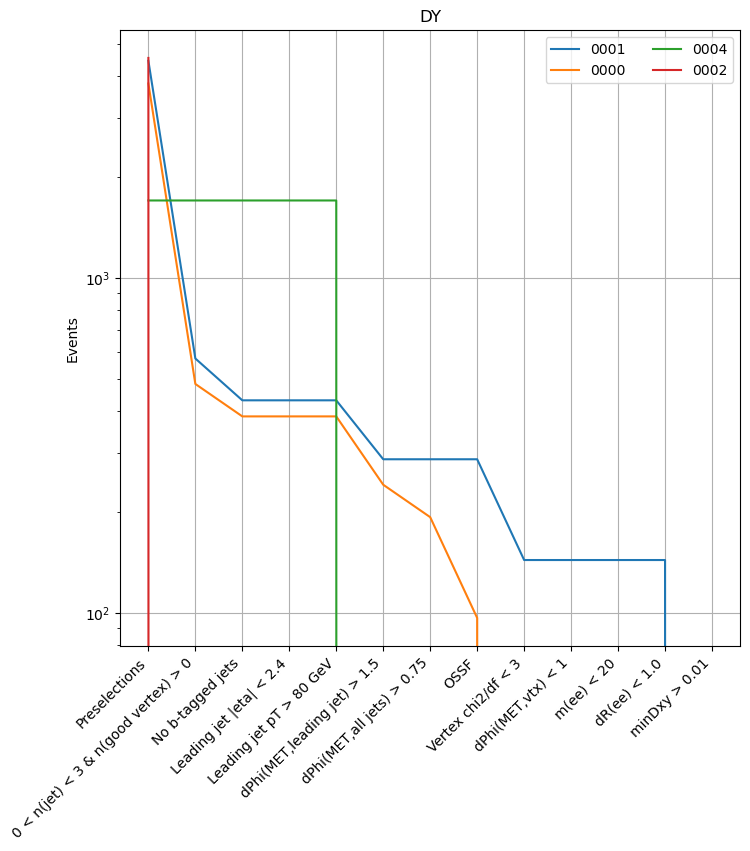

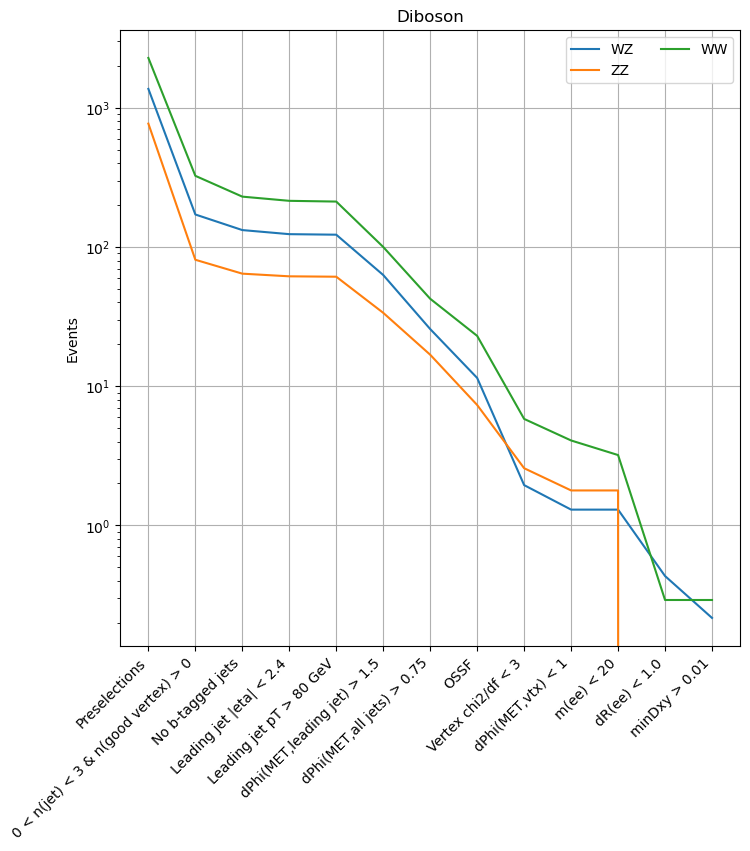

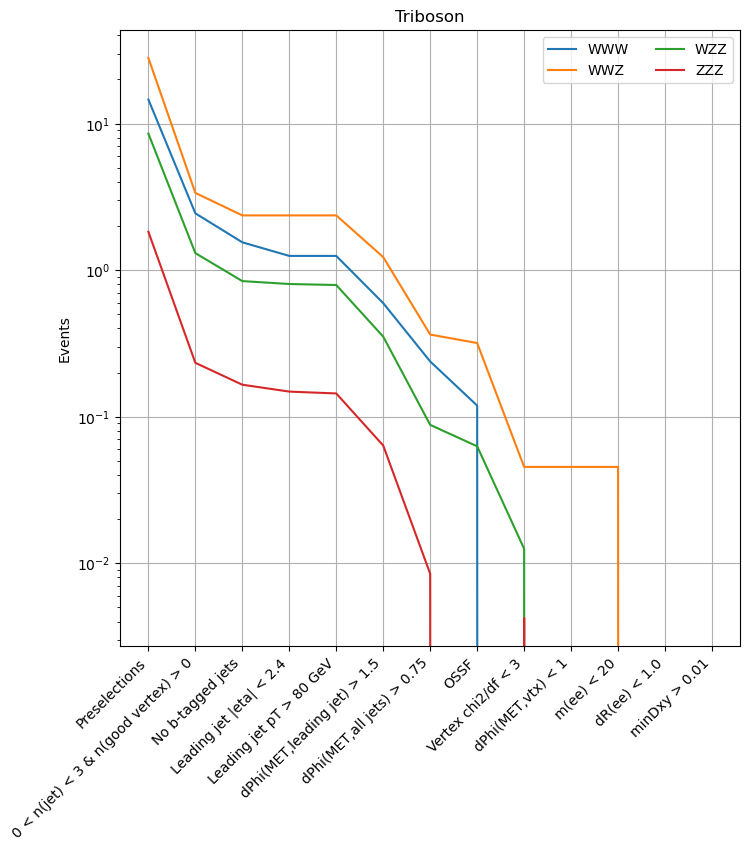

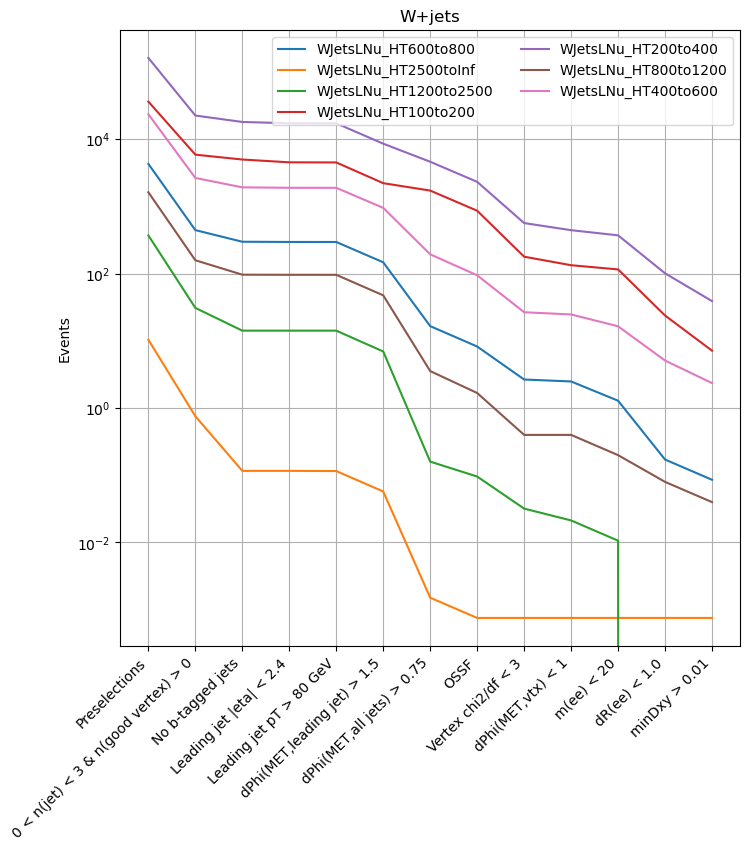

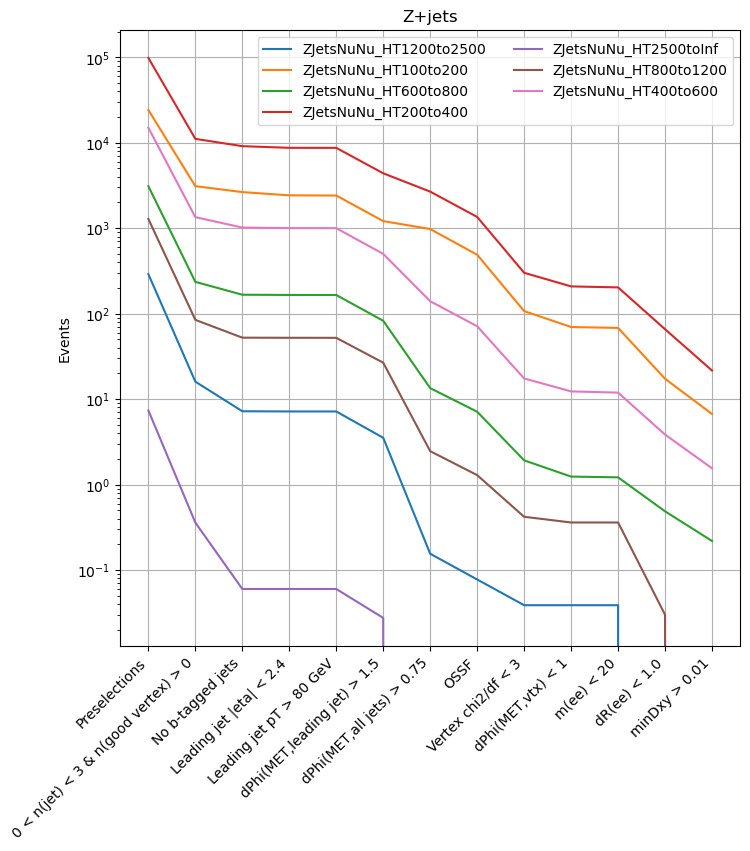

In [66]:
# bkg counts
for b in bkg_histos.keys():
    cfbs = bkg_histos[b]['cutflow_cts']
    #print(cfbs.keys())
    plt.figure(figsize=(8,8))
    plt.title(b)
    subsamples = list(cfbs.keys())
    for bkg_pt in subsamples:
        cf = cfbs[bkg_pt]
        #print(cf)
        effs = [cf[c] for c in cuts]
        plt.plot(np.arange(len(effs)),effs,label=bkg_pt[9:])
    #plt.ylim([1e-12,1])
    plt.yscale('log')
    plt.ylabel('Events')
    plt.legend(loc='upper right',ncol=2)
    plt.grid()
    #plt.xlabel("Cut Number")

    labels = [cutNames[c] for c in cuts]
    # Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
    cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
    cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))
    
    plt.xticks(ticks = np.arange(len(cuts)), labels = cut, rotation = 45, ha = 'right')
    
    #plt.savefig(f"plots/cutflows/bkg_{b}_counts_pdf")
    #plt.close()